In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.externals import joblib

/home/veruska/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
file_path = '../../data/input/integrated_data_dummy.csv'

data = pd.read_csv(file_path)
data = data.sort_values(["busCode","busCodeSB"])

In [3]:
# FILTERING HIGHER HEADWAYS (2% of the data)
# two_hours = 120
# data = data[data.headway <= two_hours]

In [3]:
data.isnull().any()

route                                      False
tripNum                                    False
shapeSequence                              False
shapeLat                                   False
shapeLon                                   False
                                           ...  
alertTypeSB_ROAD_CLOSED                    False
jamBlockTypeSB_-                           False
jamBlockTypeSB_NORMAL                      False
jamBlockTypeSB_ROAD_CLOSED_CONSTRUCTION    False
jamBlockTypeSB_ROAD_CLOSED_EVENT           False
Length: 419, dtype: bool

In [3]:
target_col = ['headway']
bb_col = ['busBunching']
hd_threshold = ["headwayThreshold"]
features = list(set(list(data.columns))-set(target_col)-set(bb_col)-set(hd_threshold))

In [4]:
# Get label column and remove it from data
y = data['headway']
y_threshold = data['headwayThreshold']

data.drop('headway', axis=1, inplace=True)
data.drop('busBunching', axis=1, inplace=True)
data.drop('headwayThreshold', axis=1, inplace=True)

In [5]:
# Normalize data
min_max_scaler = preprocessing.MinMaxScaler()
data_scale = min_max_scaler.fit_transform(data)

In [6]:
# Making training and test data: 80% Training, 20% Test
random.seed(15) #to get always the same set
train_X, test_X, train_Y, test_Y = train_test_split(data_scale, y, test_size=0.20, random_state=7)

In [7]:
def rmse_cv(model, X_train, y_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5))
    return(rmse)

# function to plot the RMSE vs parameter value
def plot_rmse_param(series, param_name):
    series.plot(title = "Validation Error vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    
# function to get the best RMSE and the best parameter value of the model
def best_rmse_param(series):
    best_rmse = series.min()
    best_param = series.idxmin() 
    
    return(best_rmse, best_param)

In [7]:
del data
del y

### Random Forest

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

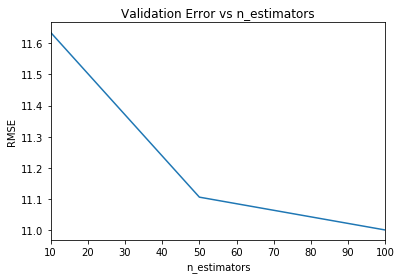

In [9]:
start = time.time()

n_estimators = [10, 50, 100] #number of trees
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = n, n_jobs=-1), train_X, train_Y).mean() 
            for n in n_estimators]

series = pd.Series(cv_rf_rmse, index = n_estimators)
plot_rmse_param(series, "n_estimators")
best_rmse_rf, best_estimator_rf = best_rmse_param(series)

In [ ]:
n_min_samples_split = [5, 10, 15, 20, 25]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = best_estimator_rf, min_samples_split = n, n_jobs=-1), 
                      train_X, train_Y).mean() 
            for n in n_min_samples_split]

series = pd.Series(cv_rf_rmse, index = n_min_samples_split)
plot_rmse_param(series, "n_min_samples_split")
best_rmse_rf, best_split_rf = best_rmse_param(series)

/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs 

In [ ]:
n_features = [0.25, 0.33, 0.5, 0.75, 0.8]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators=best_estimator_rf, min_samples_split=best_split_rf,
                                            max_features=n, n_jobs=-1), 
                      train_X, train_Y).mean() 
            for n in n_features]

series = pd.Series(cv_rf_rmse, index = n_features)
plot_rmse_param(series, "max_features")
best_rmse_rf, best_max_feat_rf = best_rmse_param(series)

In [8]:
best_estimator_rf = 100
#best_split_rf = 5
#best_max_feat_rf = 0.75

In [ ]:
random.seed(42)

try:
    start
except NameError: # start does not exist at all
    start = time.time()

rf = RandomForestRegressor(n_estimators=best_estimator_rf, min_samples_split=best_split_rf,
                           max_features=best_max_feat_rf, n_jobs=-1)
rf.fit(train_X, train_Y)

end = time.time()
print("Execution time: " + str((end - start)/60) + " min")

In [9]:
# Saving a pickle file for the model
joblib.dump(rf, 'Saved_RF_x_gps_gtfs_waze.pkl')

NameError: name 'rf' is not defined

### Evaluating model

R2 coefficient (score) of determination is a statistical measure of how well the regression predictions approximate the real data points. The best one is 1.

In [10]:
r2 = rf.score(test_X, test_Y)
r2

0.9245764253375132

In [11]:
print(str(r2) + " of the data is been explained by the model.")

0.9245764253375132 of the data is been explained by the model.


In [ ]:
print("best_estimator_rf: " + str(best_estimator_rf))
print("best_split_rf: " + str(best_split_rf))
print("best_max_features_rf: " + str(best_max_feat_rf))

In [12]:
pred_array = rf.predict(test_X)

In [8]:
# Testing
rf_load = joblib.load('Saved_RF_100_5_075.pkl') 
pred_array = rf_load.predict(test_X)

# removing the array of each element
pred = []
for p in pred_array:
    pred.append(p)

rmse_rf = np.sqrt(mean_squared_error(test_Y, pred))
print(rmse_rf)

10.529459946364799


In [9]:
print(min(pred))
print(max(pred))

0.0
949.6261666666667


In [10]:
pred

[84.04994047619047,
 4.144606060606059,
 14.38625793650794,
 24.10532142857143,
 31.312996031746014,
 22.976226190476186,
 35.933984126984114,
 12.256059523809524,
 31.897796176046178,
 99.73038023088026,
 40.831023809523806,
 80.85045840270841,
 7.34220634920635,
 3.9499404761904757,
 6.673630952380952,
 11.573031746031747,
 34.86726587301586,
 0.7157738095238095,
 26.40075793650794,
 28.153100649350655,
 7.070642857142855,
 31.391336580086577,
 13.431841991341994,
 10.940309523809525,
 15.610281024531027,
 72.93242063492062,
 9.967563492063492,
 20.05270238095238,
 265.13374999999996,
 32.322373376623375,
 6.415464285714284,
 28.521527777777774,
 5.069222222222223,
 24.992666666666665,
 18.36175,
 3.16675,
 36.22489285714286,
 14.848516594516592,
 12.199599206349207,
 10.570051587301588,
 6.727380952380954,
 7.212730519480519,
 205.06211904761906,
 4.534944805194806,
 9.463526334776335,
 9.962190476190477,
 23.836704184704185,
 12.869437229437228,
 62.08676190476186,
 67.604765873015

In [11]:
test_Y

341586     84
573490      4
50737      12
840747     25
796060     30
           ..
1421784    16
514588      3
1169290    82
1023921    12
988420     15
Name: headway, Length: 286527, dtype: int64

In [12]:
alpha = y_threshold[test_Y.index]
alpha

341586     5
573490     4
50737      5
840747     5
796060     5
          ..
1421784    5
514588     6
1169290    5
1023921    5
988420     5
Name: headwayThreshold, Length: 286527, dtype: int64

In [13]:
bb_pred = np.less_equal(pred, alpha)
bb_label = np.less_equal(test_Y, alpha)

In [14]:
bb_pred

341586     False
573490     False
50737      False
840747     False
796060     False
           ...  
1421784    False
514588     False
1169290    False
1023921    False
988420     False
Name: headwayThreshold, Length: 286527, dtype: bool

In [15]:
bb_label

341586     False
573490      True
50737      False
840747     False
796060     False
           ...  
1421784    False
514588      True
1169290    False
1023921    False
988420     False
Length: 286527, dtype: bool

In [9]:
accuracy = accuracy_score(bb_label, bb_pred)
precision = precision_score(bb_label, bb_pred)
recall = recall_score(bb_label, bb_pred)
f_measure = f1_score(bb_label, bb_pred)

In [10]:
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9399567929025886
Precision: 0.965947242206235
Recall: 0.5742800114057599
F-measure: 0.7203147353361946


### Graphs

(-600, 600)

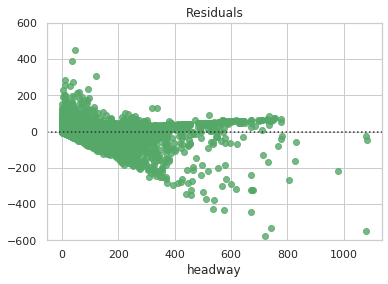

In [9]:
sns.set(style="whitegrid")

# Plot the residuals after fitting a linear model
ax = sns.residplot(test_Y, pred, color="g")
ax.set_title('Residuals')
ax.set_ylim([-600, 600])


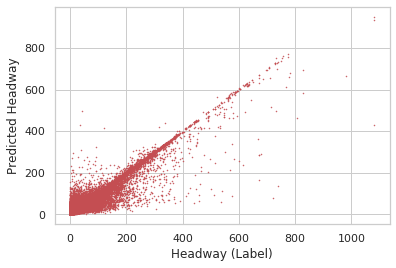

In [10]:
# Print all error to see if there is standard or some big outliers
plt.figure()
plt.plot(test_Y, pred, 'ro', ms=0.5)
# plt.ylim(10, 40)
plt.xlabel('Headway (Label)')
plt.ylabel('Predicted Headway')
plt.show()

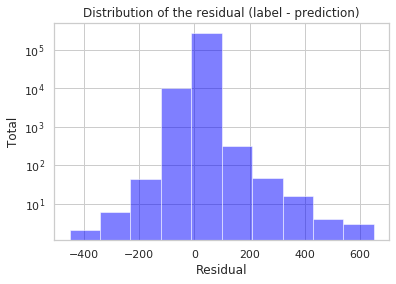

In [11]:
diff = test_Y - np.array(pred).flatten()
num_bins = 10
width = 5
height = 5
plt.hist(diff, num_bins, facecolor='blue', alpha=0.5, log=True)
plt.xlabel('Residual')
plt.ylabel('Total')
plt.title('Distribution of the residual (label - prediction)')
plt.rcParams["figure.figsize"] = (width,height) 
plt.show()

In [12]:
# Features importance

#create dictionary
f_imps = {}
for i in range(len(features)):
    f_imps[features[i]] = rf_load.feature_importances_[i]
    
#sort dictionary 
sorted_feature_names = sorted(f_imps, key=f_imps.__getitem__, reverse=True)
sorted_values = sorted(f_imps.values(), reverse=True)

num_to_print = 20
for i in range(num_to_print):
    print("%15s %4.3f" % (sorted_feature_names[i], sorted_values[i]))

shapeId_Route_320 0.224
shapeId_Route_309 0.082
shapeId_Route_120 0.074
shapeId_Route_1069 0.066
DAY(alertDateTimeSB) 0.048
shapeId_Route_561 0.046
shapeId_Route_133 0.045
shapeId_Route_1140 0.025
shapeId_Route_443 0.010
shapeId_Route_1032 0.009
shapeId_Route_547 0.008
shapeId_Route_181 0.008
          route 0.008
shapeId_Route_444 0.008
shapeId_Route_119 0.008
shapeId_Route_262 0.008
shapeId_Route_180 0.008
shapeId_Route_198 0.008
shapeId_Route_282 0.008
shapeId_Route_1391 0.007


### Analysing error prediction

In [26]:
data_test = data.loc[test_Y.index]

wrong_preds = data_test[bb_pred != bb_label]

In [27]:
wrong_preds

,route,tripNum,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,...,alertTypeSB_ACCIDENT,alertTypeSB_CHIT_CHAT,alertTypeSB_HAZARD,alertTypeSB_JAM,alertTypeSB_NORMAL,alertTypeSB_POLICE,alertTypeSB_ROAD_CLOSED,jamBlockTypeSB_-,jamBlockTypeSB_NORMAL,jamBlockTypeSB_ROAD_CLOSED_EVENT
573490,91,6,25043,-8.018930,-34.910010,9218.0,50312,360007.0,-8.018956,-34.909889,...,0,0,0,0,1,0,0,0,1,0
1344158,126,1,34683,-7.972185,-34.865406,3198.0,81796,0.0,-7.972185,-34.865406,...,0,0,0,0,1,0,0,0,1,0
24038,68,3,12692,-8.032078,-34.959203,10689.0,12040,5505.0,-8.032509,-34.959593,...,0,0,0,0,1,0,0,0,1,0
227254,31,1,4223,-8.034690,-34.949669,6198.0,12437,144186.0,-8.034790,-34.949518,...,0,0,0,0,1,0,0,0,1,0
1116614,126,6,35327,-7.951620,-34.877064,17302.0,81311,0.0,-7.951620,-34.877064,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181617,31,1,4238,-8.041238,-34.937904,7684.0,12409,0.0,-8.041238,-34.937904,...,0,0,0,1,0,0,0,1,0,0
470360,93,8,21310,-8.054282,-34.881752,1868.0,50011,0.0,-8.054282,-34.881752,...,0,0,0,0,1,0,0,0,1,0
285963,31,5,4379,-8.053088,-34.916155,4422.0,12483,139851.0,-8.053100,-34.916180,...,0,0,0,1,0,0,0,1,0,0
1343843,126,5,34895,-8.051960,-34.895680,14411.0,81795,0.0,-8.051960,-34.895680,...,0,0,0,0,1,0,0,0,1,0


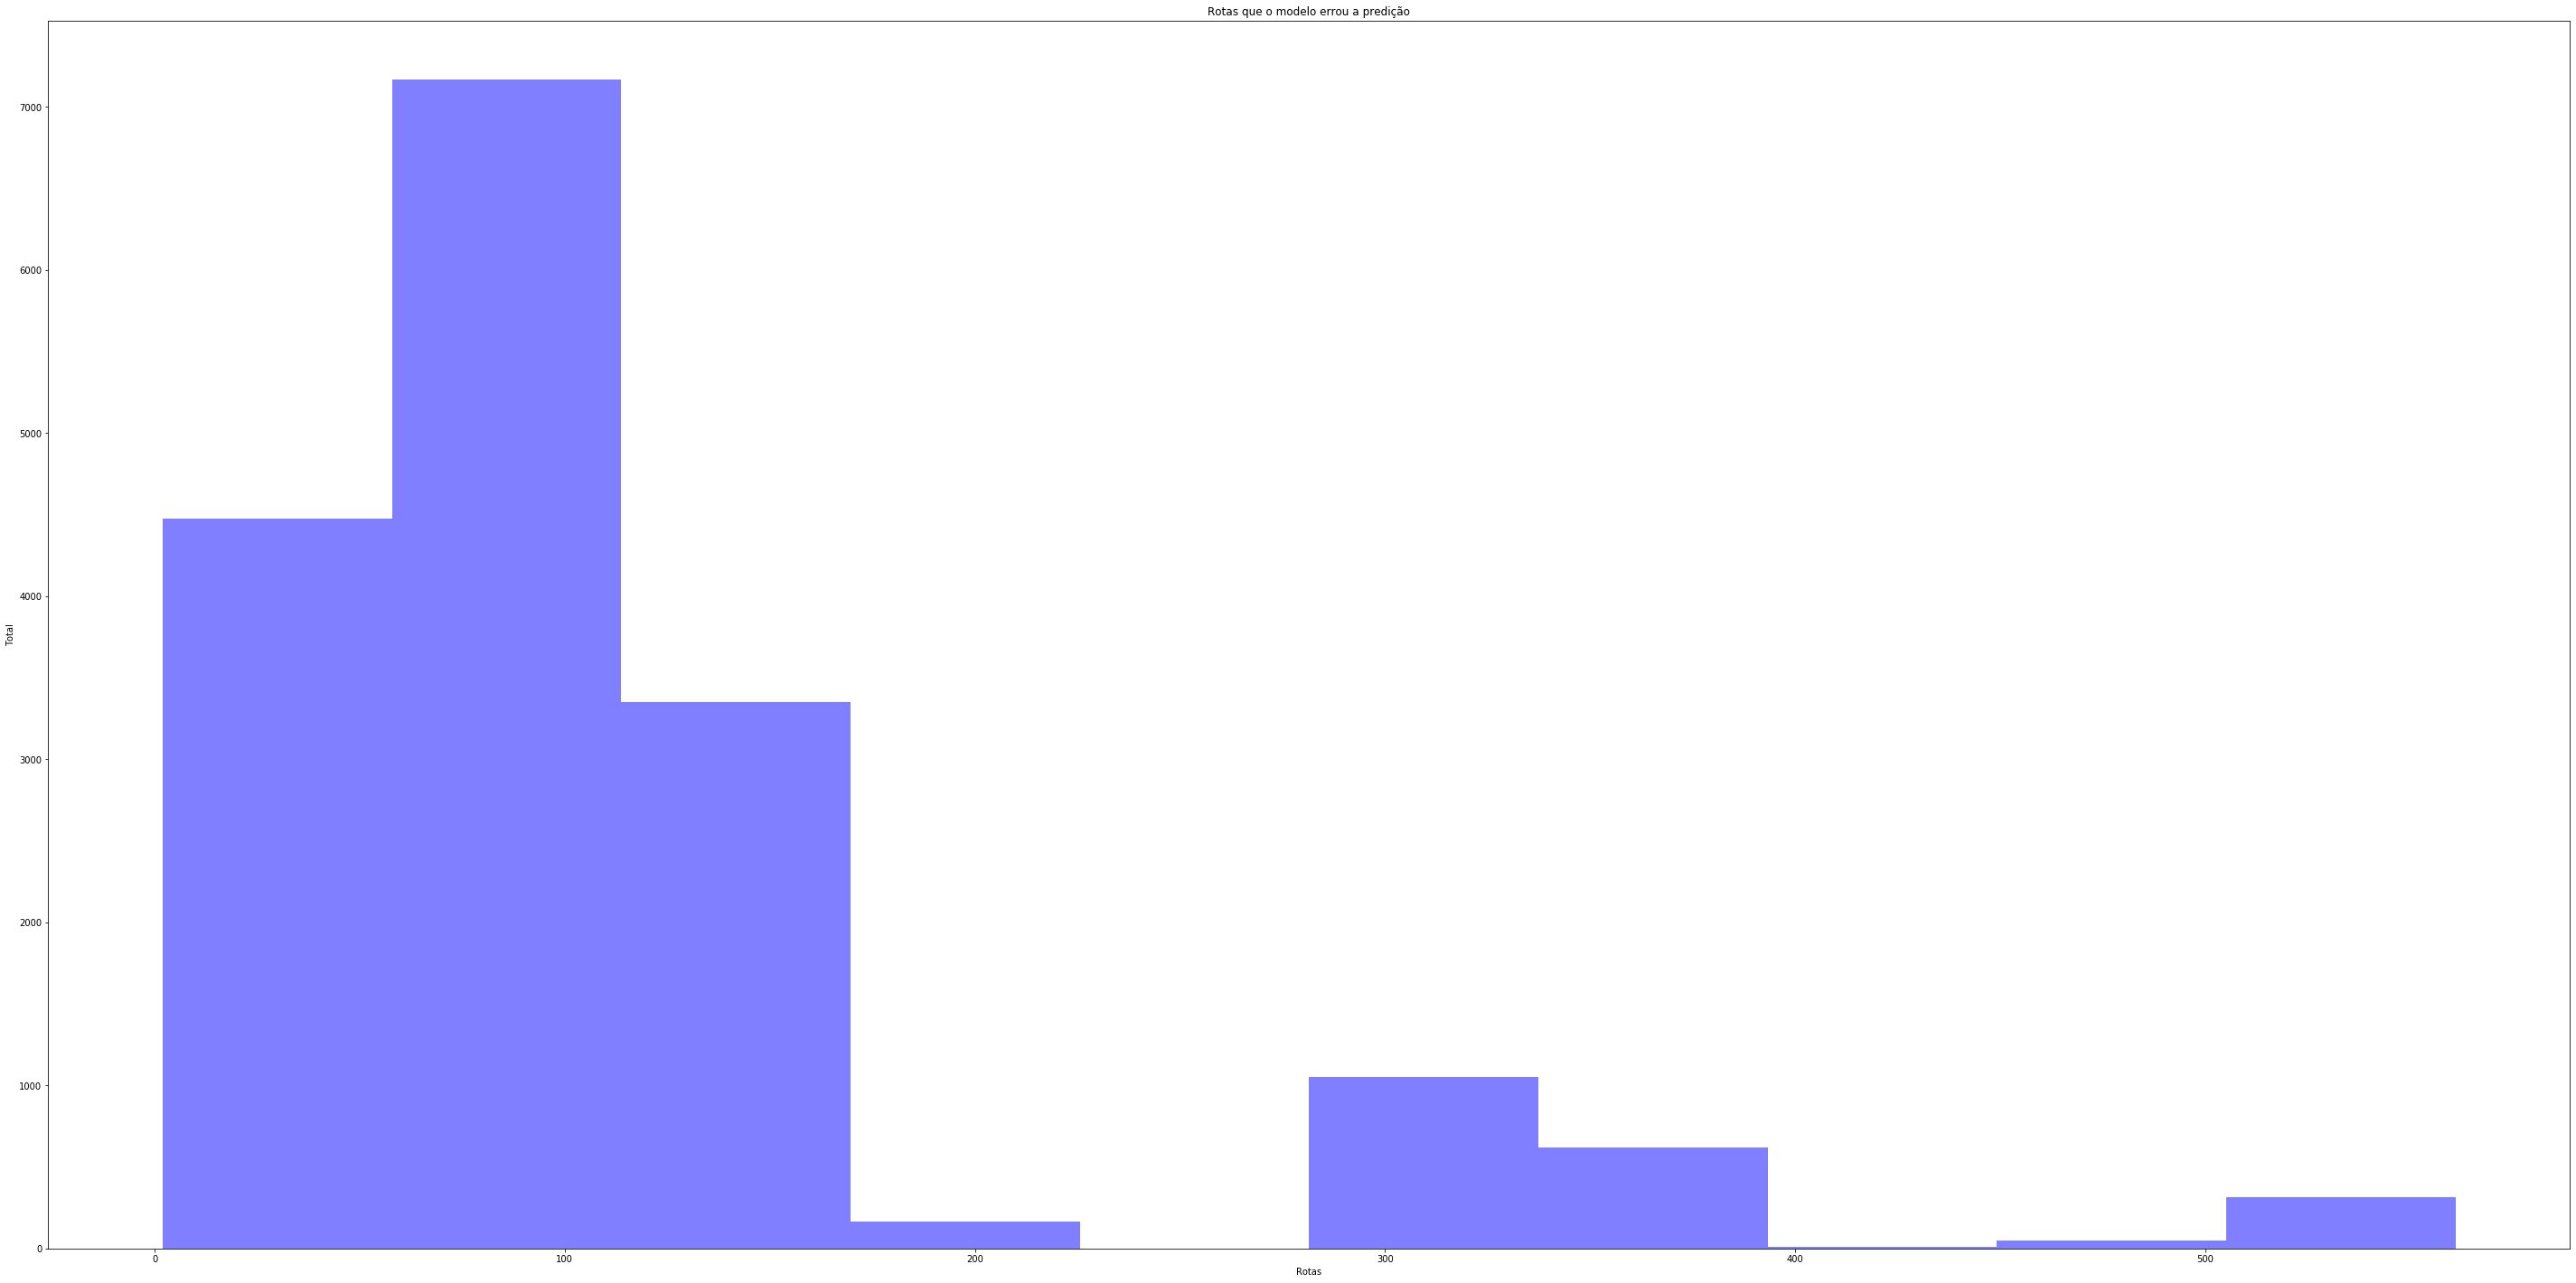

In [48]:
# num_bins = 10
# width = 50
# height = 25
plt.hist(wrong_preds.route, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Rotas')
plt.ylabel('Total')
plt.title('Rotas que o modelo errou a predição')
# plt.xticks(np.arange(0, 500, 1))
# plt.rcParams["figure.figsize"] = (width,height)
plt.show()